# DATASET과 DATALOADER
- 데이터 샘플을 처리하는 코드는 지저분하고 유지보수가 어렵다. 따라서 가독성과 모듈성을 위해 데이터셋 코드를 모델 학습 코드로부터 분리하는 것이 이상적이다.
- pytorch는 torch.utils.data.DataLoader와 torch.utils.data.Dataset의 두 가지 데이터 기본 요소를 제공한다.
- 또한 미리 준비된 데이터셋 뿐만 아니라 가지고 있는 데이터를 사용할 수 있도록 한다.

### 데이터셋 불러오기
torch vision에서 Fashion_MNIST불러오기
- 60000개의 학습예제와 10000개의 테스트 예제로 구성
- 각 에제는 흑백의 28x28 이미지와 10개 class 중 하나인 label로 구성

In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True, # 훈련 데이터 포함 O
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False, # 훈련 데이터 포함 X
    download=True,
    transform=ToTensor()
)

### 데이터셋을 순회하고 시각화하기

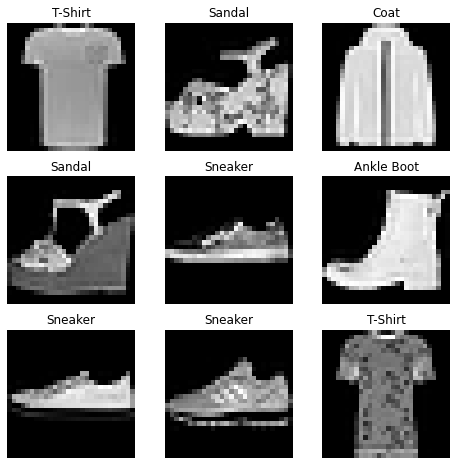

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### 파일에서 사용자 정의 데이터셋 만들기 
Dataset클래스는 반드시 3개의 함수를 구현해야한다.
- \__init\__: dataset 초기화
- \__len\__ : 데이터셋의 샘플 개수를 반환
- \__getitem\__ : 해당 idx의 image, label 반환

In [9]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### DataLoader로 학습용 데이터 준비하기
- 모델을 학습할 때, 일반적으로 샘플들을 미니배치로 전달하고, 매 에폭마다 데이터를 다시 섞어서 overfit을 막고, python의 multiprocessing을 사용하여 데이터 검색 속도를 높인다.
- DataLoader는 간단한 API로 이러한 복잡한 과정들을 추상화한 순회 가능한 객체(iterable)이다.

In [10]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

# DataLoader를 통해 순회하기(iteate)
- DataLoader에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 iterate할 수 있다.
- 아래의 각 iteration은 train_features와 train_labels의 batch를 반환한다.
- 모든 배치를 iterate한 뒤 데이터가 섞인다.      

참고     
[Sampler](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler): 순서대로 가져오는 것이 아닌 랜덤하게 가져옴

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


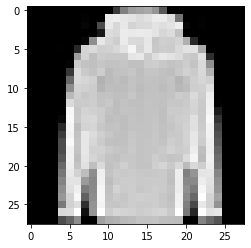

Label: 4


In [11]:
# 이미지와 정답(label)을 표시합니다.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")